In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math
import yfinance as yf

In [2]:
symbol = input("enter symbol here : ")

enter symbol here : ^NSEI


In [3]:
print(f"Fetching data for '{symbol}' using yfinance...")
try:
    # 2. Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # 3. Fetch historical market data
    data = sym_data.history(period="60d", interval="5m")

    data = data.reset_index()  # Reset index to make 'Datetime' a column

    # The column name after reset_index depends on the yfinance version,
    # it could be 'Datetime' or 'index'. We'll handle 'Datetime'.
    if "Datetime" in data.columns:
    #     # Format the 'Datetime' column to 'YYYY-MM-DD HH:MM'
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")
    elif "index" in data.columns:
        data = data.rename(columns={"index": "Datetime"})
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")

    # We now have the 'Datetime' column to include.
    data = data[["Datetime", "Open", "High", "Low", "Close"]]

    # 7. Display the final data
    print("\nHere are the last 5 data points with the formatted Datetime column:")
    print(data.tail().round(2))

except Exception as e:
    print(f"\nAn error occurred: {e}")


Fetching data for '^NSEI' using yfinance...

Here are the last 5 data points with the formatted Datetime column:
              Datetime      Open      High       Low     Close
4411  2025-09-01 15:05  24625.65  24630.05  24622.95  24628.35
4412  2025-09-01 15:10  24628.85  24631.75  24620.90  24625.75
4413  2025-09-01 15:15  24624.45  24629.40  24619.95  24628.25
4414  2025-09-01 15:20  24628.55  24631.30  24623.45  24626.80
4415  2025-09-01 15:25  24626.65  24629.60  24619.85  24624.15


In [5]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T.round(2))

summary statistics  
         count      mean     std       min       25%       50%       75%  \
Open   4416.0  24989.55  318.40  24345.20  24718.26  24980.75  25185.55   
High   4416.0  24998.34  317.58  24348.45  24725.85  24988.65  25193.81   
Low    4416.0  24980.11  319.00  24337.95  24705.83  24971.90  25177.24   
Close  4416.0  24989.26  318.17  24344.45  24718.48  24980.40  25185.30   

            max  
Open   25660.95  
High   25664.85  
Low    25639.90  
Close  25647.60  


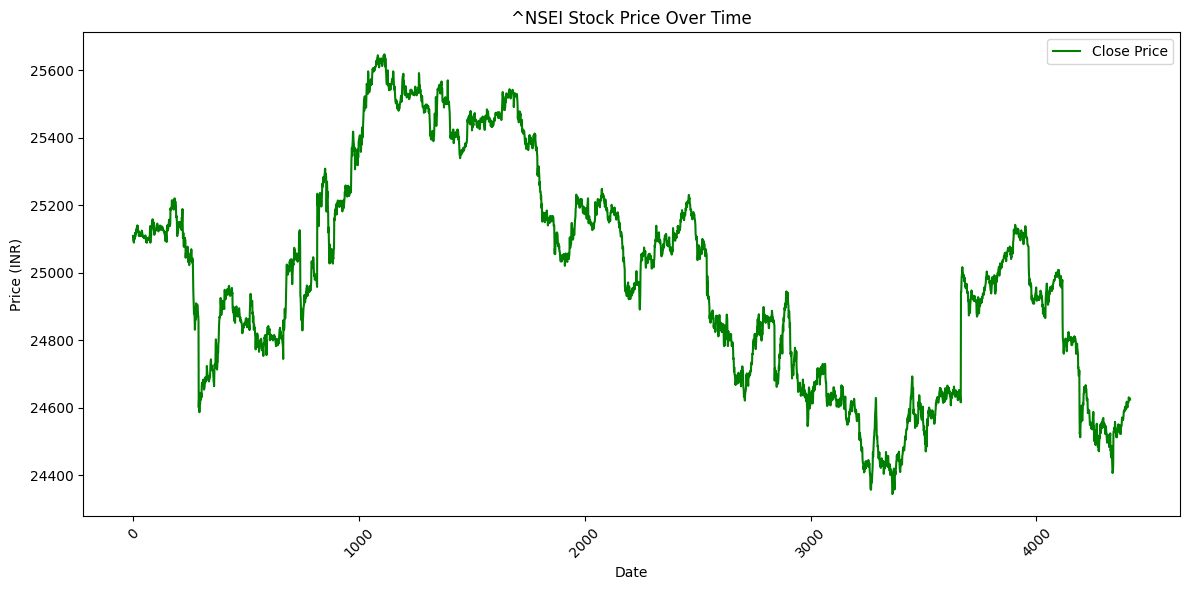

In [6]:
# stock price over the time using line chart
plt.figure(figsize=(12, 6))
sb.lineplot(data=data, x=data.index, y="Close", label="Close Price" , color="green")
plt.title(f"{symbol} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

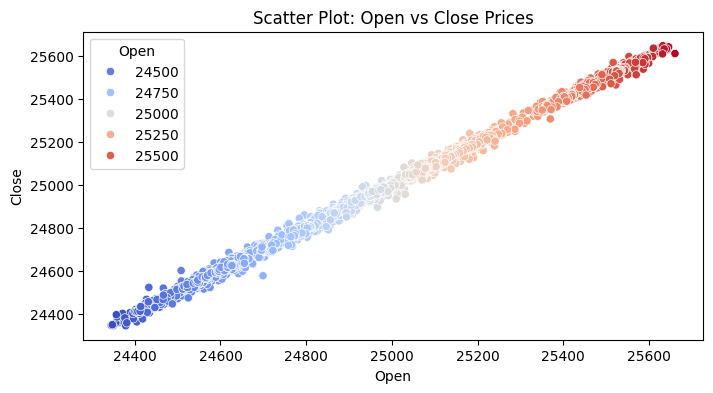

In [7]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

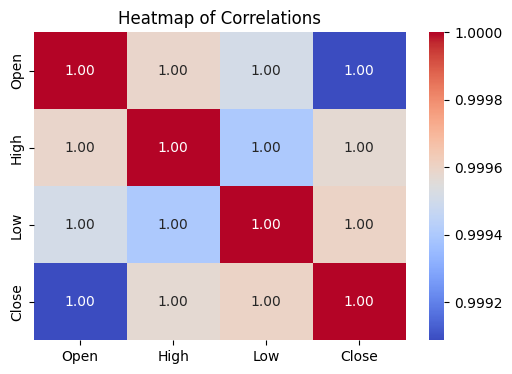

In [8]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

In [9]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))

Skewness (Close): 0.14924797720095317
Skewness (Open): 0.1481979047943708
Skewness (High): 0.15117981982065917
Skewness (Low): 0.14698000871360425


In [10]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [11]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


              Datetime      Open      High       Low     Close  Trend
4411  2025-09-01 15:05  24625.65  24630.05  24622.95  24628.35      0
4412  2025-09-01 15:10  24628.85  24631.75  24620.90  24625.75      1
4413  2025-09-01 15:15  24624.45  24629.40  24619.95  24628.25      0
4414  2025-09-01 15:20  24628.55  24631.30  24623.45  24626.80      0
4415  2025-09-01 15:25  24626.65  24629.60  24619.85  24624.15      0


In [12]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Open", "High", "Low", "Close"]])

In [13]:
def create_sequences(dataset, time_steps=90):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps)])  # past 60 days
        y.append(dataset[i + time_steps, 0])   # 'Close' is 1st column here
    # Convert to numpy arrays for better performance with LSTM
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


In [14]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (3484, 60, 4), (3484,)
Testing data shape: (872, 60, 4), (872,)


In [15]:
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict close price

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0690 - val_loss: 9.9141e-04
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0043 - val_loss: 9.0341e-04
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0036 - val_loss: 9.8228e-04
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0036 - val_loss: 8.1962e-04
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 8.7937e-04
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 8.5838e-04
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 9.3371e-04
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 7.0635e-04
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 6.6651e-04
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 7.2822e-04
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 6.1741e-04
Ep

In [16]:
# Predictions
y_pred = model.predict(X_test)
# Inverse transform (to get actual prices back)
# y_test and y_pred are scaled — need to bring them back

# Create empty array for inverse scaling
y_test_inv = np.zeros((len(y_test), scaled_data.shape[1]))
y_pred_inv = np.zeros((len(y_pred), scaled_data.shape[1]))

# Put the close price predictions back in the correct column
y_test_inv[:, 3] = y_test
y_pred_inv[:, 3] = y_pred[:, 0]

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_inv)[:, 3]
y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, 3]

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [17]:
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 score:", r2)

RMSE: 20.93120776126333
MAE: 13.270931575995137
R2 score: 0.9891507370786045


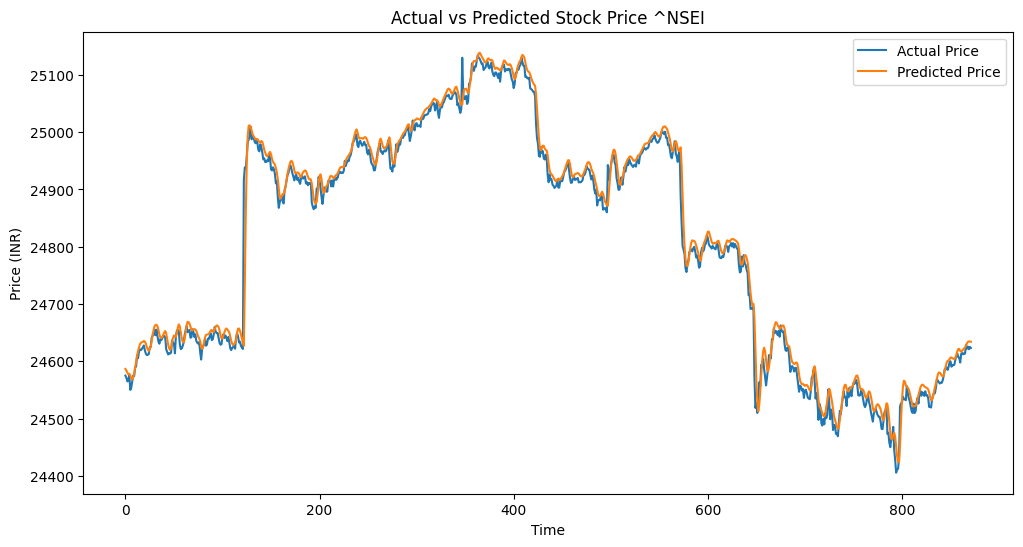

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price {symbol}")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

In [19]:
# ---User Input for Forecast Period ---
try:
    forecast_minutes = int(input("Enter the number of minutes to forecast (e.g., 15, 30, 60): "))
    if forecast_minutes <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Please enter a positive number. Defaulting to 30 minutes.")
    forecast_minutes = 30

Enter the number of minutes to forecast (e.g., 15, 30, 60): 20


In [20]:
future_steps = int(forecast_minutes / 5)
print(
    f"Forecasting for {forecast_minutes} minutes, which is {future_steps} 5-minute steps."
)

# --- 2. Corrected Forecasting Logic ---
lookback = time_steps  # time_steps = 60 from your training cell

# Start with the last 'lookback' steps from your scaled dataset (with all 5 features)
last_sequence = scaled_data[-lookback:].copy()
forecast_predictions = []

for _ in range(future_steps):
    # Reshape the sequence to be a single sample with 5 features
    X_input = np.reshape(last_sequence, (1, lookback, 4))

    # Predict the next 5-minute interval's closing price (scaled)
    pred_scaled = model.predict(X_input)[0, 0]

    # Store the scaled prediction
    forecast_predictions.append(pred_scaled)

    # Create the next input row for the sequence
    # Use the predicted close price and carry over the other features from the last step
    next_input_row = last_sequence[-1].copy()  # Get the last row of 5 features
    next_input_row[3] = pred_scaled  # Update the 'Close' price feature (index 3)

    # Append the new row and remove the oldest to maintain the sequence length
    last_sequence = np.append(last_sequence[1:], [next_input_row], axis=0)
# --- 3. Inverse Transform and Display Forecast ---

# THE FIX: Create a dummy array with 4 columns, matching the scaler
forecast_transformed = np.zeros((len(forecast_predictions), 4))

# Place the scaled predictions into the 'Close' price column (index 3)
forecast_transformed[:, 3] = forecast_predictions

# Inverse transform to get the actual price values
# THE FIX: Select the correct column (index 3) for the 'Close' price
forecast_prices = scaler.inverse_transform(forecast_transformed)[:, 3]

# --- The rest of your code for creating timestamps and plotting is correct ---

# Ensure last_timestamp is a datetime
last_timestamp = pd.to_datetime(data["Datetime"].iloc[-1])

# Use pd.date_range for cleaner timestamp generation
future_timestamps = pd.date_range(
    start=last_timestamp + pd.Timedelta(minutes=5),
    periods=future_steps,
    freq="5min",
)

forecast_df = pd.DataFrame(
    {"Timestamp": future_timestamps, "Predicted Close": forecast_prices}
)

print(f"\nPredicted Closing Prices for the Next {forecast_minutes} Minutes:")
print(forecast_df.round(2))  # Using 4 decimal places for crypto

Forecasting for 20 minutes, which is 4 5-minute steps.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Predicted Closing Prices for the Next 20 Minutes:
            Timestamp  Predicted Close
0 2025-09-01 15:30:00         24632.82
1 2025-09-01 15:35:00         24632.83
2 2025-09-01 15:40:00         24633.46
3 2025-09-01 15:45:00         24634.31
